# Analyze data

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

In [2]:
# Load all test data
X = pd.read_csv("./X_train.csv", index_col="id")
y = pd.read_csv("./Y_train.csv", index_col="id")
# Merge XY for plot
XY = pd.merge(left=X, right=y, left_on='id', right_on='id')
# Split data
RANDOM_SEED = 41
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   manufacturer    30000 non-null  object 
 1   model           30000 non-null  object 
 2   transmission    30000 non-null  object 
 3   color           30000 non-null  object 
 4   odometer        30000 non-null  int64  
 5   year            30000 non-null  int64  
 6   engineFuel      30000 non-null  object 
 7   engineType      30000 non-null  object 
 8   engineCapacity  29991 non-null  float64
 9   bodyType        30000 non-null  object 
 10  drivetrain      30000 non-null  object 
 11  photos          30000 non-null  int64  
 12  feature_0       30000 non-null  bool   
 13  feature_1       30000 non-null  bool   
 14  feature_2       30000 non-null  bool   
 15  feature_3       30000 non-null  bool   
 16  feature_4       30000 non-null  bool   
 17  feature_5       30000 non-null 

**Nhận xét**  
Dữ liệu gồm 22 feature. Trong đó:  
- 8 feature có kiểu dữ liệu "object": [manufacturer, model, transmission, color, engineFuel, engineType, bodyType, drivetrain]. 
- 4 feature có kiểu dữ liệu số "int, float": [odometer, year, engineCapacity, photos].  
- 10 feature kiểu dữ liệu "bool": [feature_0,...feature_9]
- Feature "engineCapacity" tồn tại 9 entries rỗng (Na), đây là những xe có "engineType" là "electric"

## Price

In [4]:
print(XY.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    30000.000000
mean      6599.796028
std       6096.244533
min          1.000000
25%       2300.000000
50%       4900.000000
75%       8999.000000
85%      11900.000000
90%      14000.000000
100%     50000.000000
max      50000.000000
Name: price, dtype: float64


**Nhận xét**  
- Dữ liệu phân phối không đều vì có sự chênh lệch giữa “mean”  và “median”.  
- Đồng thời 75% xe (trong dữ liệu) có giá dưới 8999, 15% xe có giá từ 8999 đến 14000. 10% xe có giá từ 14000 đến 50000.

## Manufacturer

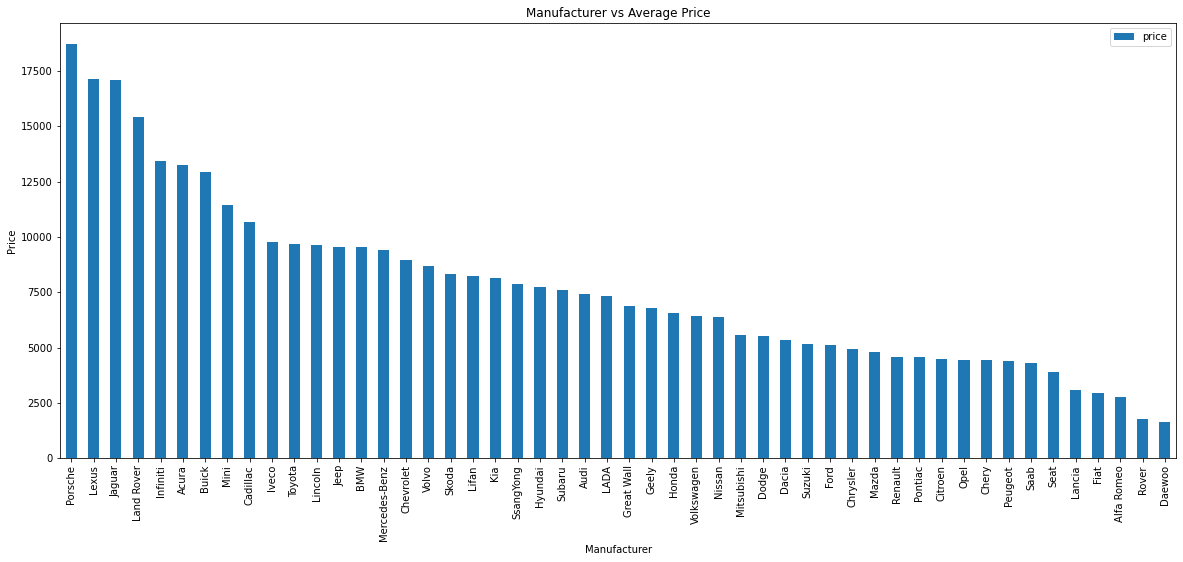

In [5]:
df = pd.DataFrame(XY.groupby(['manufacturer'])['price'].mean().sort_values(ascending = False))
df.plot.bar(figsize=(20,8))
plt.title('Manufacturer vs Average Price')
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.show()

**Nhận xét**  
- Phần lớn manufature sản xuất xe có giá dưới 10000 (trung bình).
- Gần 50% manufature có giá TB dưới 7500.
- Hơn 10% manufature có giá TB trên 12500.  
$\longrightarrow$ Cần thử TH dummies manufature thành 3 nhóm [0,7500,12500,20000]

## Transmission

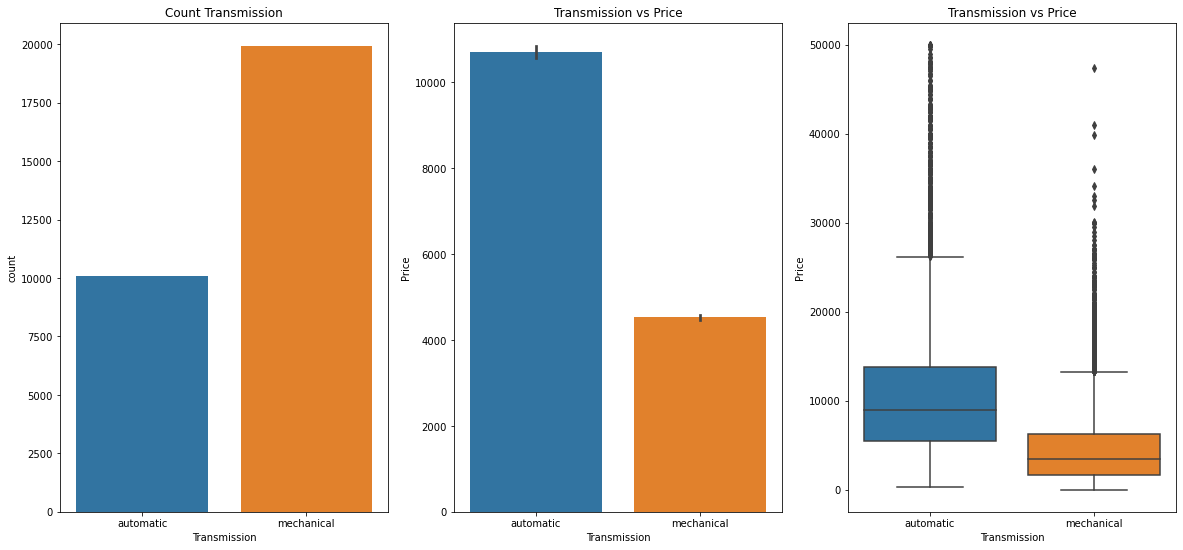

In [6]:
plt.figure(figsize=(20,9))
plt.subplot(1,3,1)
sns.countplot(XY['transmission']).set(xlabel = "Transmission")
plt.title("Count Transmission")
plt.subplot(1,3,2)
plt.title('Transmission vs Price')
sns.barplot(x=XY.transmission, y=XY.price).set(xlabel='Transmission',ylabel="Price")
plt.subplot(1,3,3)
plt.title('Transmission vs Price')
sns.boxplot(x=XY.transmission, y=XY.price).set(xlabel='Transmission',ylabel="Price")
plt.show()

**Nhận xét**  
- Xe "automatic" có giá cao hơn so với "mechanical"

## Color

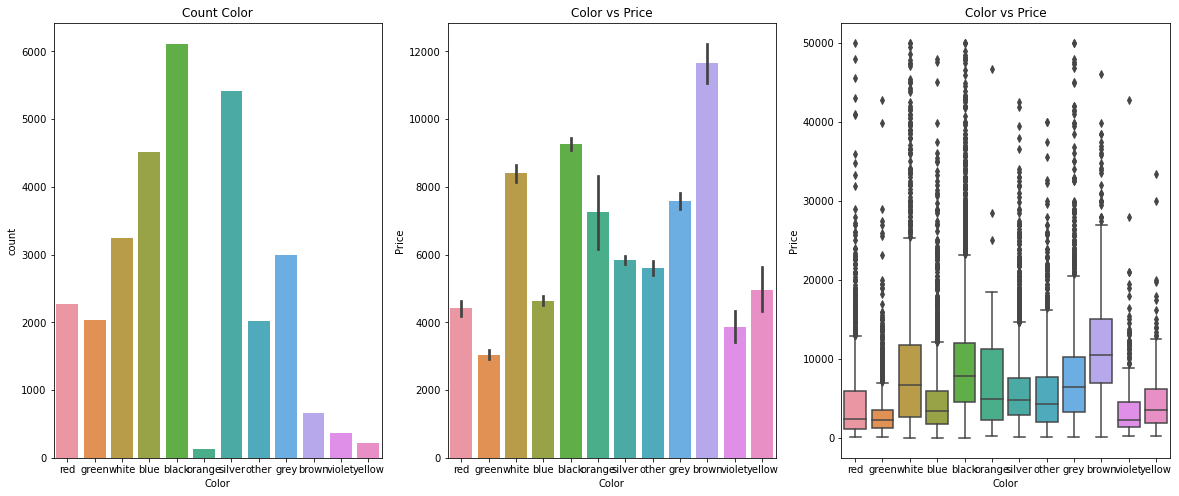

In [7]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
sns.countplot(XY['color']).set(xlabel = "Color")
plt.title("Count Color")
plt.subplot(1,3,2)
plt.title('Color vs Price')
sns.barplot(x=XY.color, y=XY.price).set(xlabel='Color',ylabel="Price")
plt.subplot(1,3,3)
plt.title('Color vs Price')
sns.boxplot(x=XY.color, y=XY.price).set(xlabel='Color',ylabel="Price")
plt.show()

**Nhận xét**  
- Nhìn chung sự chênh lệch màu không quá nhiều, chỉ một số màu có sự đột biến về giá (black, brown, white).  
$\longrightarrow$ Cần thử trường các trường hợp tách màu như việc giữ lại 3 màu trên và chuyển các màu khác thành other.

## EngineFuel và EngineType

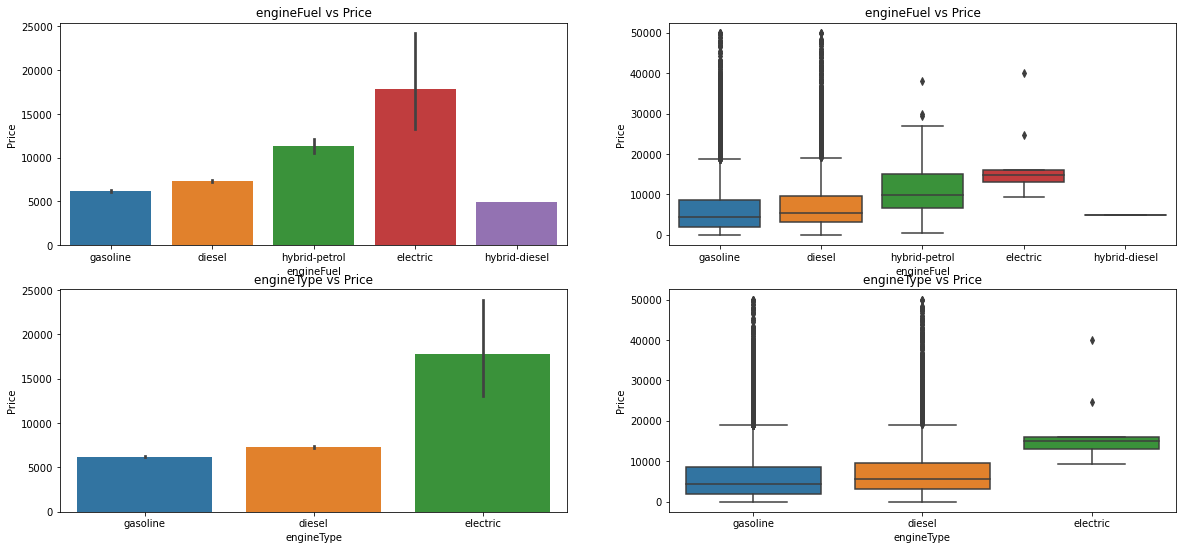

In [8]:
plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.title('engineFuel vs Price')
sns.barplot(x=XY.engineFuel, y=XY.price).set(xlabel='engineFuel',ylabel="Price")
plt.subplot(2,2,2)
plt.title('engineFuel vs Price')
sns.boxplot(x=XY.engineFuel, y=XY.price).set(xlabel='engineFuel',ylabel="Price")
plt.subplot(2,2,3)
plt.title('engineType vs Price')
sns.barplot(x=XY.engineType, y=XY.price).set(xlabel='engineType',ylabel="Price")
plt.subplot(2,2,4)
plt.title('engineType vs Price')
sns.boxplot(x=XY.engineType, y=XY.price).set(xlabel='engineType',ylabel="Price")
plt.show()

**Nhận xét**  
- Feature "engineFuel" và "engineType" bao hàm nhau. Nghĩa là nếu quan tâm đến nhãn "hybrid" thì Feature "engineFuel" mang tính quyết định, lúc này có thể bỏ đi Feature "engineType".  
$\longrightarrow$ Việc chọn hay bỏ Feature nào được quyết định thông qua chạy thử model ở dưới.

## BodyType

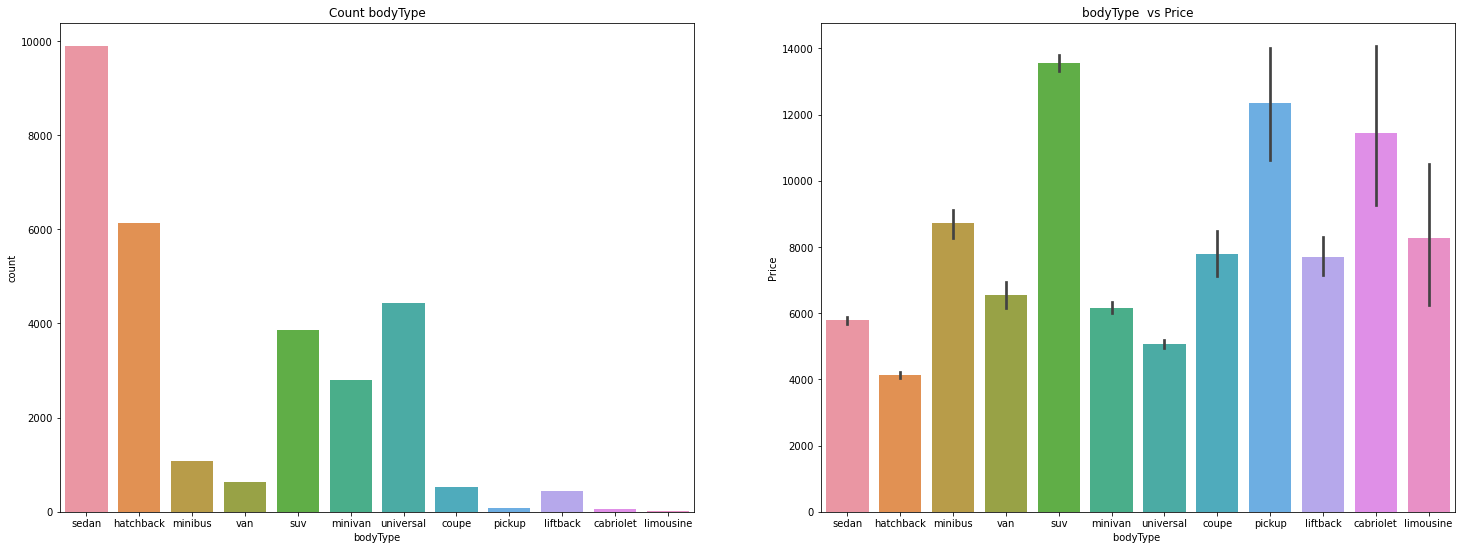

In [9]:
plt.figure(figsize=(25,9))
plt.subplot(1,2,1)
plt.title("Count bodyType")
sns.countplot(XY['bodyType']).set(xlabel = "bodyType")
plt.subplot(1,2,2)
plt.title('bodyType  vs Price')
sns.barplot(x=XY.bodyType, y=XY.price).set(xlabel='bodyType ',ylabel="Price")
plt.show()

**Nhận xét**  
- Từ biểu đồ và theo thực tế, feature này có thể sẽ ảnh hưởng đến giá tiền.  
$\longrightarrow$ Tuy nhiên cần phải thử tách các trường hợp đặc biệt như với feature color.

## Drivetrain

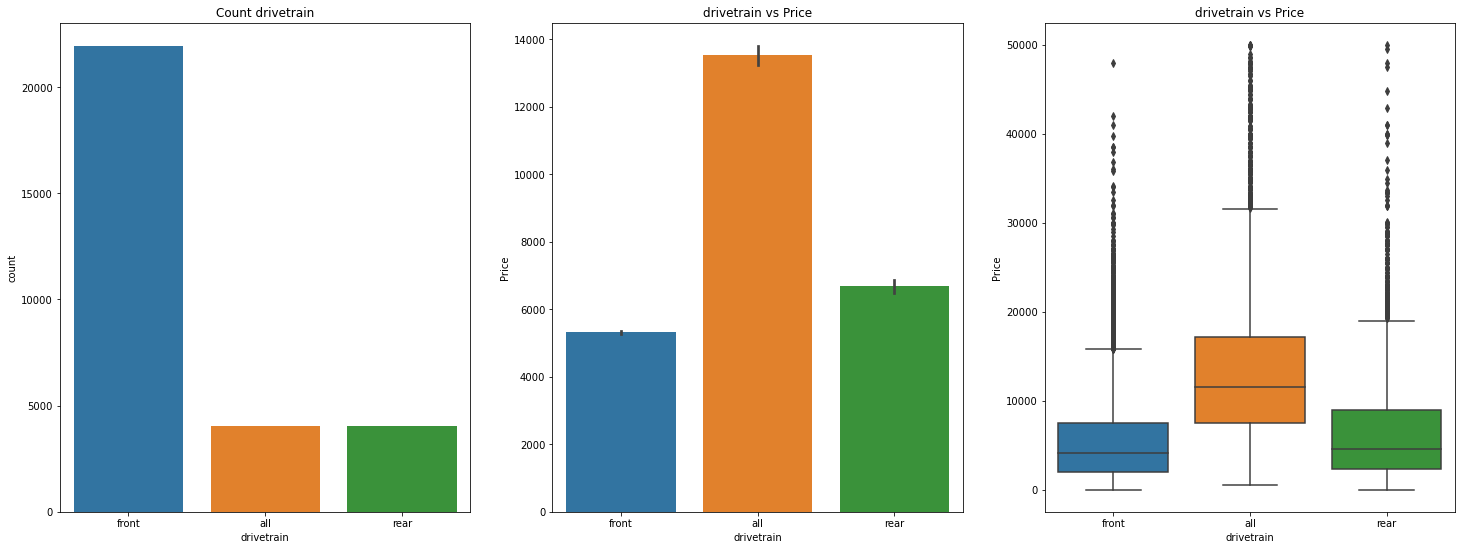

In [10]:
plt.figure(figsize=(25,9))
plt.subplot(1,3,1)
sns.countplot(XY['drivetrain']).set(xlabel = "drivetrain")
plt.title("Count drivetrain")
plt.subplot(1,3,2)
plt.title('drivetrain vs Price')
sns.barplot(x=XY.drivetrain, y=XY.price).set(xlabel='drivetrain',ylabel="Price")
plt.subplot(1,3,3)
plt.title('drivetrain vs Price')
sns.boxplot(x=XY.drivetrain, y=XY.price).set(xlabel='drivetrain',ylabel="Price")
plt.show()

**Nhận xét**  
- Với feature này, những xe "all" có giá vượt trội hẳn so với "front" và "rear"

## Odometer - Year

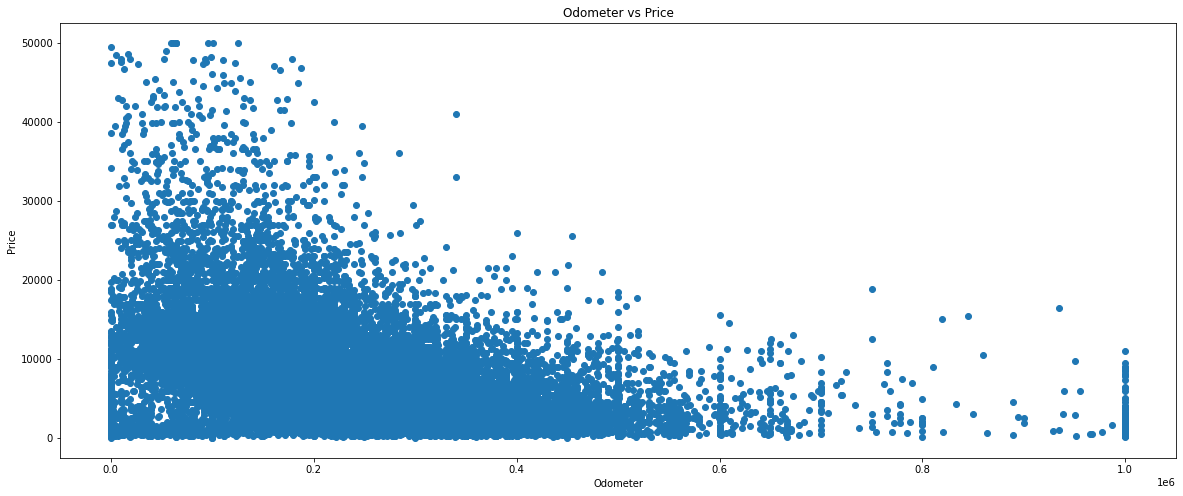

In [11]:
plt.figure(figsize=(20,8))
plt.scatter(XY['odometer'],XY['price'])
plt.title('Odometer vs Price')
plt.ylabel('Price')
plt.xlabel('Odometer')
plt.show()

**Nhận xét**  
- Odometer có khả năng lớn ảnh hướng nhiều đến Price.  
- Odometer càng cao thì Price càng bé.
$\longrightarrow$ Phần dưới sẽ thử transform feature này. (VD: $x^2$, $x^3$,...)

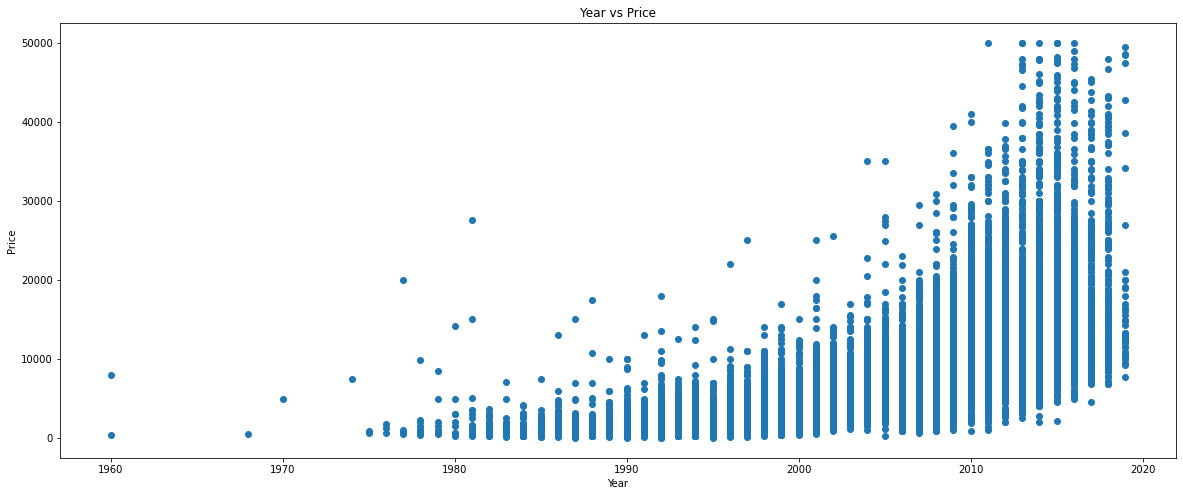

In [12]:
plt.figure(figsize=(20,8))
plt.scatter(XY['year'],XY['price'])
plt.title('Year vs Price')
plt.ylabel('Price')
plt.xlabel('Year')
plt.show()

**Nhận xét**  
- Year có khả năng lớn ảnh hướng nhiều đến Price.  
- Những xe có năm sản xuất càng gần 2020 thì giá có khả năng cao hơn.
$\longrightarrow$ những feature có thể ảnh hưởng như feature "year", cần thử thêm nhiều transform của feature.  

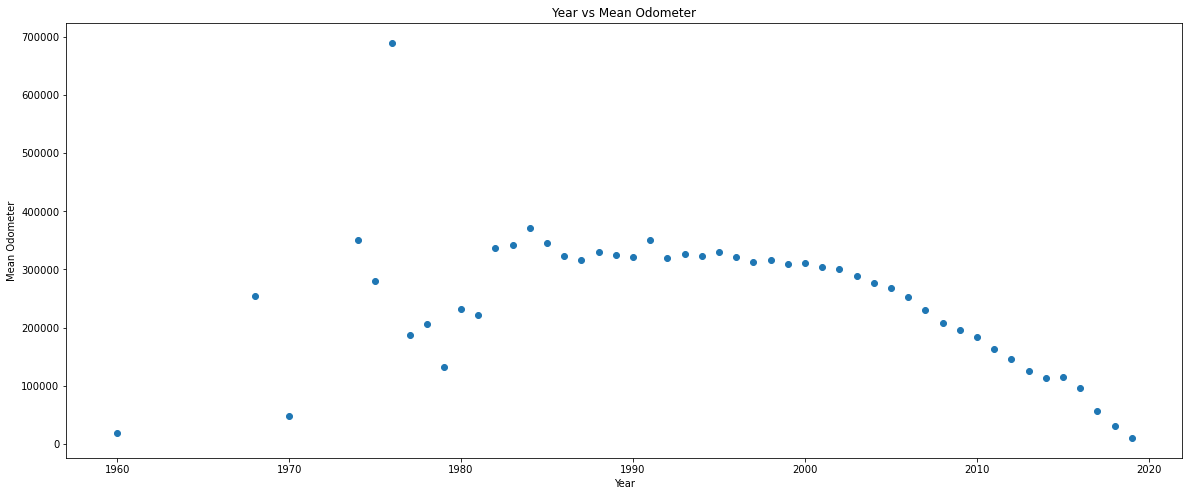

In [13]:
df = pd.DataFrame(XY.groupby(['year'])['odometer'].mean())
df = df.reset_index()
plt.figure(figsize=(20,8))
plt.scatter(df['year'],df['odometer'])
plt.title('Year vs Mean Odometer')
plt.ylabel('Mean Odometer')
plt.xlabel('Year')
plt.show()

**Nhận xét**  
- Có sự phụ thuộc lớn giữa 2 feature "odometer" và "year".
- Tuy nhiên những xe trước năm 1982, trung bình "odometer" nhảy thất thường so với sau 1982. Sẽ thử gán dữ liệu ảo cho các xe 1982 để xem model có đẹp hơn hay không.  
- Ngoài ra thông qua thông số "odometer" và "year", một số xe có year rất xa hiện tại nhưng odometer lại cực kỳ nhỏ (có nhưng xe chỉ là 100 hoặc 10). Có thể nhưng odometer này là số ảo.

## EngineCapacity và Photos

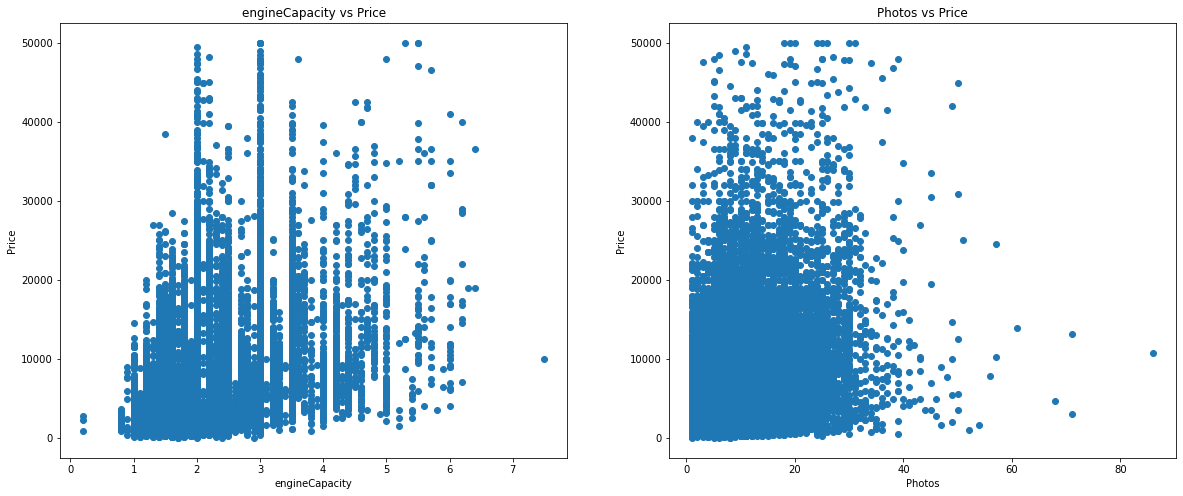

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(XY['engineCapacity'],XY['price'])
plt.title('engineCapacity vs Price')
plt.xlabel('engineCapacity')
plt.ylabel('Price')
plt.subplot(1,2,2)
plt.scatter(XY['photos'],XY['price'])
plt.title('Photos vs Price')
plt.xlabel('Photos')
plt.ylabel('Price')
plt.show()

**Nhận xét**  
- Nhìn chung 2 feature trên sẽ không ảnh hướng đến giá.  
Tuy nhiên khi thực hiện drop feature thì kết quả sẽ thấp hơn so với không drop.

## Correlation table

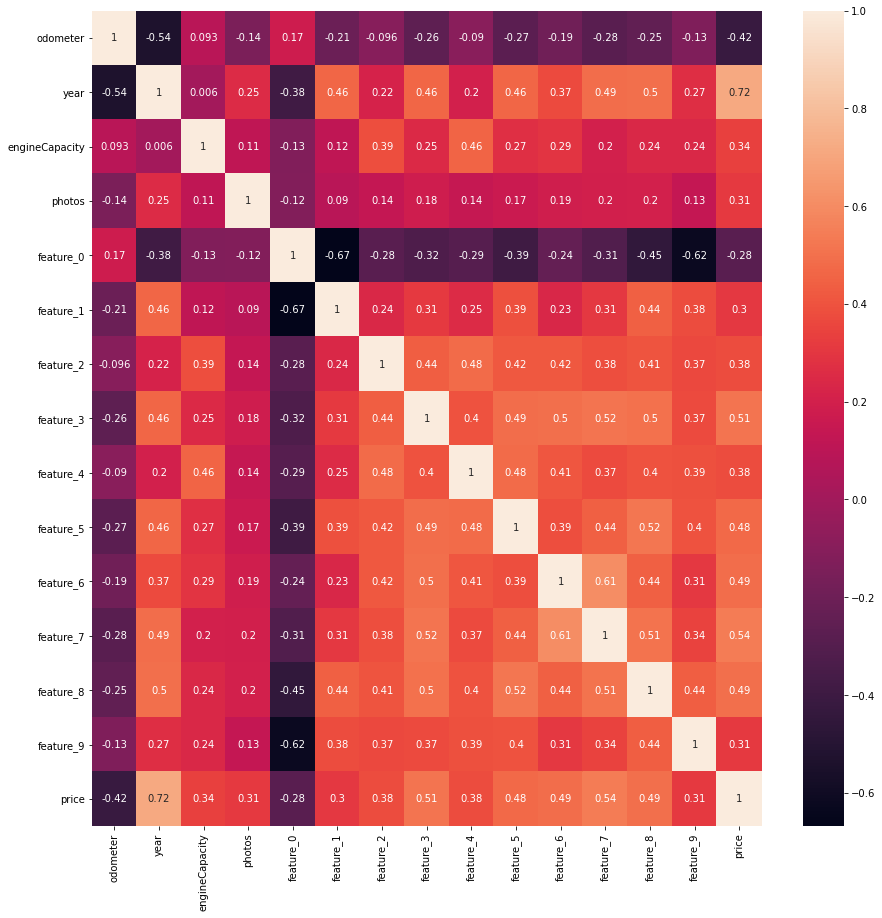

In [15]:
plt.figure(figsize=[15,15])
sns.heatmap(XY.corr(),annot=True)
plt.show()

- Giá trị trên biểu đồ thể hiện cho độ tương quan giữa các feature.  
- Số càng về 1 hoặc -1 càng cho thấy 2 feature này liên hệ với nhau và ngược lại.

# Train Model

## Standardize features

*Hàm sử dụng: sklearn.preprocessing.StandardScaler*  
Mục tiêu: Transform dữ liệu sao cho trung bình của dữ liệu là 0 và có độ lệch chuẩn là 1.  
Ý nghĩa: Bình đẳng các feature, tránh việc giá trị của feature nào đó quá lớn ảnh hướng đến các feature còn lại.

**Công thức**  
$$z = \frac{x-u}{s}$$

**Trong đó**  
x: giá trị ban đầu trong dữ liệu.  
z: giá trị mới sau khi StandardScaler.  
u: trung bình tất cả các mẫu của feature đang xét.  
s: độ lệch chuẩn tất cả các mẫu của feature đang xét.

## Replace missing value

*Hàm sử dụng: sklearn.impute.SimpleImputer*  
Mục tiêu: Thay thế các giá trị rỗng thành giá trị mới. Ở đây em chọn thay thế bằng giá trị **trung vị** của dữ liệu.

## Function

**Train function**  
Em dùng pipeline để gói gọn các bước Train model theo thứ tự.  
- num_pipeline: Gồm các bước tiền xử lý số liệu dạng number  
Thêm (xoá) thuộc tính mới $\rightarrow$ Xử lý missing value $\rightarrow$ Chuẩn hoá dữ liệu.  
- obj_pipeline: Gồm các bước tiền xử lý số liệu dạng object  
Thêm (xoá) thuộc tính mới $\rightarrow$ Dummy feature.  
- bool_pipeline: Gồm các bước tiền xử lý số liệu dạng boolean  
Pipeline này sẽ xử lý việc AND OR cho các feature bool. Thêm hoặc bớt đi một số feature nếu cần. 

**Test function**  
- Một số (rất ít) KQ sau khi predict là số âm.
Giữa việc chuyển về 0 và lấy trị tuyệt đối thì lấy trị tuyệt đối dù sao vẫn ra KQ gần với giá ban đầu hơn là đưa về 0.  
$\rightarrow$ KQ sau predict sẽ được lấy trị tuyệt đối

In [16]:
def train(X_train, y_train):
    num_pipeline = make_pipeline(AddCustomAttributes_num(), SimpleImputer(strategy="median"), StandardScaler())
    obj_pipeline = make_pipeline(AddCustomAttributes_obj(), OneHotEncoder(handle_unknown="ignore"))
    ct = make_column_transformer(
        (num_pipeline, make_column_selector(dtype_include=np.number)),
        (AddCustomAttributes_bool(), make_column_selector(dtype_include=bool)),
        (obj_pipeline, make_column_selector(dtype_include=object)))
    clf = make_pipeline(ct, LinearRegression())
#     clf = make_pipeline(ct, Ridge(alpha=0.50))
    clf.fit(X_train, y_train)
    return clf

def test(model, X_test, y_test):
    y_pred_test = model.predict(X_test)
    y_pred_test = np.absolute(y_pred_test)
    print("MAE(X_test, y_test) =", mean_absolute_error(y_pred_test, y_test))
    print("RMSE(X_test, y_test) =", mean_squared_error(y_pred_test, y_test, squared=False))
#     return y_pred_test

## Baseline Model

- Train với tất cả các feature (22 feature).  
- Feature "Object" xử lý bằng phương pháp dummy variables.  
- Feature "Float". Nếu missing: thay thế bằng median, scale bằng phương pháp chuẩn hoá (Standardize)

In [17]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
baseline = train(X_train, y_train)
test(baseline, X_test, y_test)

MAE(X_test, y_test) = 1540.9392846638843
RMSE(X_test, y_test) = 2626.9587329827896


## Model 1

**Thay đổi so với Baseline**  
- Thêm thuộc tính "yearSquare" vào data.  
Vì theo đồ thị (Mục Analyze Data) thì feature "year" ảnh hưởng rất nhiều đến giá trị của xe.

In [18]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop([], axis=1)
        return X
model = train(X_train, y_train)
test(model, X_test, y_test)

MAE(X_test, y_test) = 1368.0794796702028
RMSE(X_test, y_test) = 2356.7031233297525


**Kết quả:** RMSE giảm rất nhiều.

## Model 2

Từ dữ liệu em thấy được các xe có năm sản xuất càng gần với hiện tại (2020) thì giá càng cao.  
**Thay đổi so với Model 1**  
- Thêm thuộc tính "carAge" là khoảng cách giữa năm sản xuất với hiện tại.
Em thử mũ thuộc tính "carAge" lần lượt 1,2,3,4,5,... Thì nhận thấy $carAge^3$ làm cho RMSE giảm rõ nhất.

In [19]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
model = train(X_train, y_train)
test(model, X_test, y_test)

MAE(X_test, y_test) = 1344.5447620444102
RMSE(X_test, y_test) = 2326.6916930817883


## Model 3

**Thay đổi so với Model 2**  
- Thêm thuộc tính "odometerYear" là KQ của phép nhân "odometer" với "year".

In [20]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X["odometerYear"] = X["odometer"]*X["year"]
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
model = train(X_train, y_train)
test(model, X_test, y_test)

MAE(X_test, y_test) = 1344.7878258478647
RMSE(X_test, y_test) = 2326.6544156884893


## Model 4

**Thay đổi so với Model 3**  
- Thêm thuộc tính "odometerInvert" là nghịch đảo của "odometer"

In [21]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop([], axis=1)
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
model = train(X_train, y_train)
test(model, X_test, y_test)

MAE(X_test, y_test) = 1344.8971314927128
RMSE(X_test, y_test) = 2326.918815941469


## Model 5

**Thay đổi so với Model 4**  
- Feature "engineFuel" với Feature "engineType" gần như giống nhau, khác là "engineFuel" có thêm 2 nhãn "hybrid" mà số lượng dữ liệu mang nhãn "hybrid" không nhiều.  
Nên em quyết định xoá đi Feature "engineFuel"

In [22]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop([], axis=1)
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(['engineFuel'],axis=1)
        return X
model = train(X_train, y_train)
test(model, X_test, y_test)

MAE(X_test, y_test) = 1342.9895223125723
RMSE(X_test, y_test) = 2322.898587910023


**KQ:** Có những random của data train sẽ làm RMSE tăng nhẹ. Nhưng phần lớn random sẽ làm giảm RMSE.

## Model 6

**Thay đổi so với Model 5**  
Dựa trên biểu đồ tương quan giữa "odometer" và "year" và biểu đồ "count year". Em thấy rằng:  
- Tổng số xe sản xuất trước năm 1982 rất ít so với tổng số xe đang xét. 
- Odometer trung bình của các xe xs trước 1982 rất loạn, không đẹp như những xe sau 1982.  
$\rightarrow$ Vậy nên em quyết định tạo giá trị odometer giả (370,000) cho những xe xs trước 1982.

In [23]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop([], axis=1)
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X['odometer'] = np.where(X['year']<=1982, 370000, X['odometer'])
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(['engineFuel'],axis=1)
        return X
model = train(X_train, y_train)
out_test = test(model, X_test, y_test)

MAE(X_test, y_test) = 1342.7064179213835
RMSE(X_test, y_test) = 2320.9121267210235


**KQ:** RMSE có giảm. Tuy nhiên ở một số random data, RMSE có tăng ít.

## Model 7

**Thay đổi so với Model 6**  
- Thay đổi một số feature dạng boolean.  
Vì theo bảng Correlation table, một số feature có độ tương quan khá cao, nên em thử một số phép toán cho những feature bool này.

In [24]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['feature_01'] = X['feature_0'] & X['feature_1']
        X['feature_09'] = X['feature_0'] & X['feature_9']
        X['feature_67'] = X['feature_6'] & X['feature_7']
        X = X.drop(['feature_0','feature_1','feature_9','feature_6','feature_7'],axis=1)
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X['odometer'] = np.where(X['year']<=1982, 370000, X['odometer'])
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(['engineFuel'],axis=1)
        return X
model = train(X_train, y_train)
out_test = test(model, X_test, y_test)

MAE(X_test, y_test) = 1342.0414159884424
RMSE(X_test, y_test) = 2317.5699441739002


# Final Model

- Train với 100% dữ liệu
- Lưu model ra file 

**Lưu ý!!!**  
Load model từ file cần định nghĩa là các hàm AddCustonAttributes thì model mới chạy được.

In [25]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['feature_01'] = X['feature_0'] & X['feature_1']
        X['feature_09'] = X['feature_0'] & X['feature_9']
        X['feature_67'] = X['feature_6'] & X['feature_7']
        X = X.drop(['feature_0','feature_1','feature_9','feature_6','feature_7'],axis=1)
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X['odometer'] = np.where(X['year']<=1982, 370000, X['odometer'])
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(['engineFuel'],axis=1)
        return X
    
model_final = train(X, y)
# Save model
model_final_filename = "model_final.pkl"
with open(model_final_filename, 'wb') as file:
    pickle.dump(model_final, file)

In [26]:
class AddCustomAttributes_bool(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X['feature_01'] = X['feature_0'] & X['feature_1']
        X['feature_09'] = X['feature_0'] & X['feature_9']
        X['feature_67'] = X['feature_6'] & X['feature_7']
        X = X.drop(['feature_0','feature_1','feature_9','feature_6','feature_7'],axis=1)
        return X
class AddCustomAttributes_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X["yearSquare"] = X["year"]**2
        X["carAgeCube"] = (2020 - X["year"])**3
        X['odometer'] = np.where(X['year']<=1982, 370000, X['odometer'])
        X["odometerYear"] = X["odometer"]*X["year"]
        X["odometerInvert"] = 1 / X["odometer"]
        X = X.drop([],axis=1)
        return X
class AddCustomAttributes_obj(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(['engineFuel'],axis=1)
        return X
    
# Load model
model_final_filename = "model_final.pkl"
with open(model_final_filename, 'rb') as file:
    model_input = pickle.load(file)

#Run test
X_test = pd.read_csv("./X_train.csv", index_col="id")
y_test = pd.read_csv("./Y_train.csv", index_col="id")

test(model_input, X_test, y_test)

MAE(X_test, y_test) = 1219.8497283456136
RMSE(X_test, y_test) = 2006.3380310915254
